## Starting with Michael Wood-Vasey's notebook as a starting point
## Craig Lage - 27Aug18

## Make a brighter-fatter kernel from a set of high-intensity flats measured at UC Davis.
Michael Wood-Vasey  (2018-08-21)

1. Set up a basic repo with the raw flats
2. Use  `MakeBrighterFatterKernelTask` to construct a BF kernel
3. Visualize the kernels and compare PhoSim, ImSim, HSC, and lab-based ITL.

With substantial help from Merlin Fisher-Levine.

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib


lsst_distrib          16.0+3     	current w_2018_26 setup


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# if running stack v16.0, silence a long matplotlib Agg warning with:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
# Test to make sure that we can import obs_lsstCam
import lsst.obs.base
import lsst.obs.lsstCam

In [4]:
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask
from lsst.daf.persistence import Butler
from lsst.pipe.tasks.ingest import IngestTask

In [5]:
!pwd

/sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks


## Try to Ingest some flats from UC Davis measurements

In [6]:
!ls /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514??????.fits

/mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514141655.fits


In [7]:
# Don't need to run this each time
!rm -rf ucd_repo
! mkdir ucd_repo
! echo "lsst.obs.lsstCam.LsstCamMapper" > ucd_repo/_mapper

# Ingest the  flats. The ?00 and ?01 are the flat pairs
! ingestImages.py ucd_repo /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_?00_20180514??????.fits --mode link
! ingestImages.py ucd_repo /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_?01_20180514??????.fits --mode link

root INFO: Loading config overrride file '/sandbox/cslage/Research/LSST/code/w_2018_26/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514141655.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo/raw/100/R21/00000100-R21-S11-det085-000.fits
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_200_20180514143548.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo/raw/200/R21/00000200-R21-S11-det085-000.fits
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_300_20180514145807.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo/raw/300/R21/00000300-R21-S11-det085-000.fits
ingest INFO: /mnt/stor

In [5]:
butler = Butler('ucd_repo')


So I got this far, and it seems to have successfully ingested the images.  So far, all I have done is:

     (1) edit obs_lsstCam/config/ingest.py to use some different header values
     (2) edit obs_lsstCam/python/lsst/obs/lsstCam/ingest.py to work with these different values and 
     to fudge the raft and sensor IDs.
    

It's encouraging that I created a butler, but is the right information there???

In [9]:
print(butler.queryMetadata('src', ['visit', 'detector', 'filter', 'id', 'raftName', 'detectorName']))
print(butler.datasetExists('src'))


[(100, 85, 'r', 1, 'R21', 'S11'), (200, 85, 'r', 2, 'R21', 'S11'), (300, 85, 'r', 3, 'R21', 'S11'), (400, 85, 'r', 4, 'R21', 'S11'), (500, 85, 'r', 5, 'R21', 'S11'), (101, 85, 'r', 6, 'R21', 'S11'), (201, 85, 'r', 7, 'R21', 'S11'), (301, 85, 'r', 8, 'R21', 'S11'), (401, 85, 'r', 9, 'R21', 'S11'), (501, 85, 'r', 10, 'R21', 'S11')]
False


In [7]:
# Put in the approximate measured gain values
amp_names = ['C{:02d}'.format(i) for i in range(18)]
ucd_gain = 4.5
nominalGain = {a: ucd_gain for a in amp_names}
gain = nominalGain
dataRef = butler.dataRef('brighterFatterGain', dataId={'detector': 85}) 
dataRef.put(gain, 'brighterFatterGain')

Why doesn't the dataset exist???

Try calculating the brighter-fatter kernel using `MakeBrighterFatterKernelTask`. 

In [8]:
args = ['ucd_repo', '--rerun', 'test',
        '--id', 'detector=85',
        '--visit-pairs', '100,101', '200,201', '300,301', '400,401', '500,501',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=False',
        '--clobber-config', '--clobber-versions'
       ]

command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

ucd_pb_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py ucd_repo --rerun test --id detector=85 --visit-pairs 100,101 200,201 300,301 400,401 500,501 -c xcorrCheckRejectLevel=2 doCalcGains=False --clobber-config --clobber-versions
Skipped enforcing doOverscan as key was not present in config dict
Skipped enforcing doApplyGains as key was not present in config dict
Skipped enforcing normalizeGains as key was not present in config dict
Skipped enforcing doGuider as key was not present in config dict
Skipped enforcing doStrayLight as key was not present in config dict
Skipped enforcing doTweakFlat as key was not present in config dict
Skipped enforcing doOverscan as key was not present in config dict
Skipped enforcing doApplyGains as key was not present in config dict
Skipped enforcing normalizeGains as key was not present in config dict
Skipped enforcing doGuider as key was not present in config dict
Skipped enforcing doStrayLight as key was not present in config dict
Skipped enforcing doTweakFlat as key was not pre

In [11]:
#Finally, it ran!
ucd_detector = 85
test_butler = Butler('ucd_repo/rerun/test')
ucd_bf_kernel = test_butler.get('brighterFatterKernelNew', dataId={'raftName': 'R21', 'detectorName': 'S11', 'detector': ucd_detector})

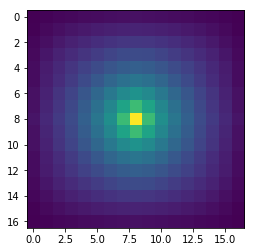

In [14]:
plt.imshow(ucd_bf_kernel[ucd_detector])
plt.show()

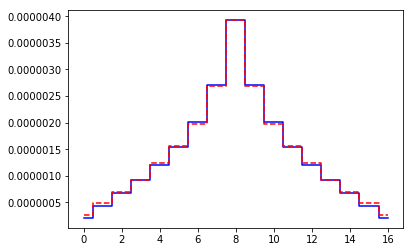

In [15]:
plt.plot(ucd_bf_kernel[ucd_detector][:,8], color='blue', drawstyle='steps-mid')
plt.plot(ucd_bf_kernel[ucd_detector][8,:], linestyle='--', color='red', drawstyle='steps-mid')
plt.show()


Ignore warnings.